In [2]:
from pandas import read_excel
import numpy as np
from numpy.linalg import eigh
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.pyplot.ion()
%matplotlib inline 
import pickle

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.mds_qlpdb import QUBO_to_Ising, find_offset, AnnealOffset

from qlp.tdse import (
    s_to_offset,
    AnnealSchedule,
    plot_anneal_schedule,
    TDSE,
    embed_qubo_example,
)

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw

-0.0


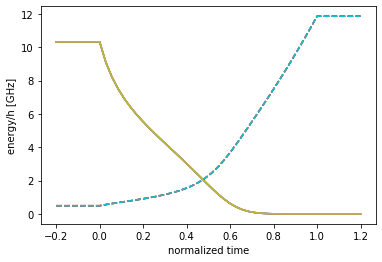

dE [  0.          34.91603055  37.30582326  38.99028377  40.76964537
  43.3004315   73.02860333  73.94134522  74.18279542  76.47106795
  78.08248498  78.119641    79.71577853  82.12938881  82.23102348
  83.27611925 112.03258307 113.08158102 113.17069416 115.57827857
 117.17419619 117.21560475 118.82225971 121.11413372 121.36843861
 122.27912356 152.02664512 154.52816485 156.31522962 157.99033562
 160.40492268 195.32430194]
pr [1.00000000e+000 3.04344797e-049 1.45443223e-052 6.63890660e-055
 2.23682672e-057 6.80841984e-061 3.35013426e-102 1.80628464e-103
 8.34229488e-104 5.51668000e-107 3.18109368e-109 2.82453725e-109
 1.71031931e-111 7.57372864e-115 5.47124318e-115 1.93152885e-116
 2.12876586e-156 7.42199934e-158 5.58079598e-158 2.51942700e-161
 1.52664211e-163 1.33720835e-163 7.82915248e-166 5.11802816e-169
 2.26850705e-169 1.23118206e-170 5.69444297e-212 1.90340661e-215
 6.25696370e-218 2.94282885e-220 1.29909316e-223 3.91158763e-272] total 1.0
Num. degenerate states @ s=1.2: 2
[[  2

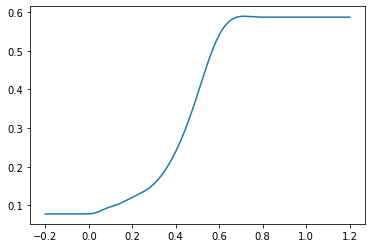

<Figure size 432x288 with 0 Axes>

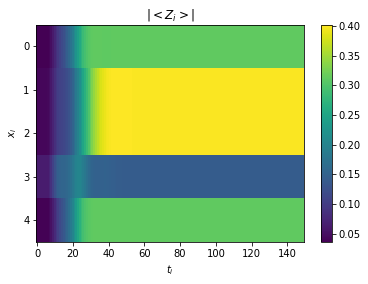

<Figure size 432x288 with 0 Axes>

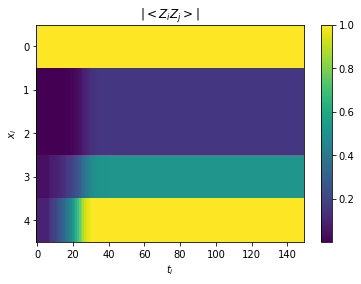

<Figure size 432x288 with 0 Axes>

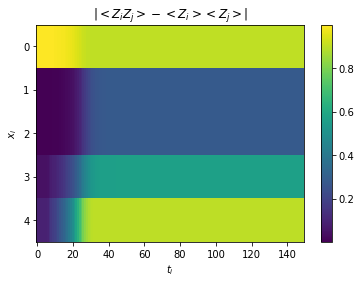

<Figure size 432x288 with 0 Axes>

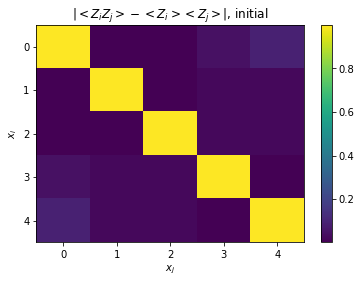

<Figure size 432x288 with 0 Axes>

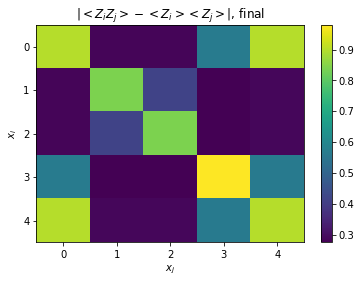

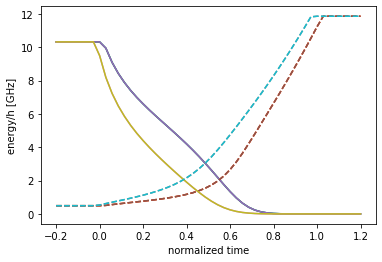

dE [  0.          34.91603055  37.30582326  38.99028377  40.76964537
  43.3004315   73.02860333  73.94134522  74.18279542  76.47106795
  78.08248498  78.119641    79.71577853  82.12938881  82.23102348
  83.27611925 112.03258307 113.08158102 113.17069416 115.57827857
 117.17419619 117.21560475 118.82225971 121.11413372 121.36843861
 122.27912356 152.02664512 154.52816485 156.31522962 157.99033562
 160.40492268 195.32430194]
pr [1.00000000e+000 3.04344797e-049 1.45443223e-052 6.63890660e-055
 2.23682672e-057 6.80841984e-061 3.35013426e-102 1.80628464e-103
 8.34229488e-104 5.51668000e-107 3.18109368e-109 2.82453725e-109
 1.71031931e-111 7.57372864e-115 5.47124318e-115 1.93152885e-116
 2.12876586e-156 7.42199934e-158 5.58079598e-158 2.51942700e-161
 1.52664211e-163 1.33720835e-163 7.82915248e-166 5.11802816e-169
 2.26850705e-169 1.23118206e-170 5.69444297e-212 1.90340661e-215
 6.25696370e-218 2.94282885e-220 1.29909316e-223 3.91158763e-272] total 1.0
Num. degenerate states @ s=1.2: 2
[[  2

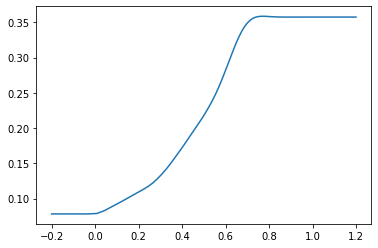

<Figure size 432x288 with 0 Axes>

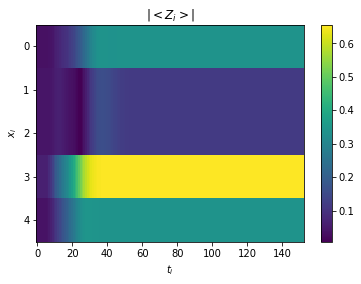

<Figure size 432x288 with 0 Axes>

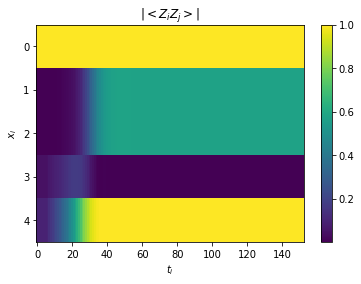

<Figure size 432x288 with 0 Axes>

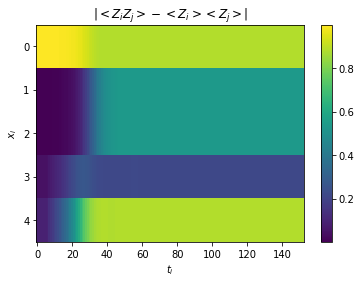

<Figure size 432x288 with 0 Axes>

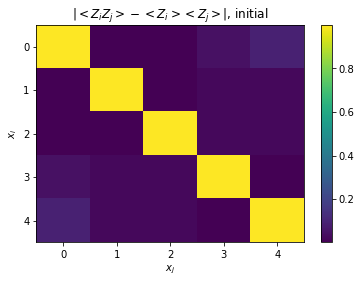

<Figure size 432x288 with 0 Axes>

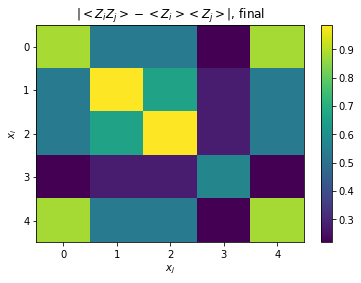

In [49]:
# brute force solving time-dependent schrodinger equation to simulate quantum annealing for small systems
result = dict()
offset_min_list = -0.05 * np.arange(2)
for offset_min in offset_min_list:
    print(offset_min)
    nvertices = 2
    graph, tag = gt.generate_nn_graph(nvertices)
    penalty = 2
    embed = True  # nvertices = [2] available

    annealing_time = 0.0003  # microseconds set by normalized_time [0, 1]
    normalized_time = [-0.2, 1.2]  # make larger range for complete offsets

    offset = "negbinary"
    anneal_curve = "dwave"  # "linear", "logistic" or "dwave".
    fill_value = "truncate"  # "extrapolate" or "truncate" the offset. Extrapolate to simulate DWave offset.
    offset_min = offset_min
    offset_range = -2 * offset_min

    solver_params = dict()
    solver_params["method"] = "RK45"
    solver_params["rtol"] = 1e-6
    solver_params["atol"] = 1e-7

    pure_tdse = False
    mixed_tdse = True
    temp = 15e-3  # temperature in kelvins for mixed tdse
    initial_wavefunction = "true"  # "true" or "transverse"

    degeneracy_tol = 2e-2  # label energy as degenerate to g.s. if within this fraction

    debug = True  # prints debug statements to screen
    save_result = True
    """Start Program"""
    # get qubo
    directed = False
    qubo = get_mds_qubo(
        graph, directed=directed, penalty=penalty, triangularize=True, dtype="d"
    )
    qubo_constant = penalty * nvertices
    # print("QUBO")
    # print(qubo.todense())

    # convert to Ising
    # Jij MUST BE upper triangular
    # This returns a J_ij s_i s_j + h_i s_i Ising model parameterization
    Jij, hi, c = QUBO_to_Ising(qubo.todense().tolist())
    # print(Jij)
    # print(hi)

    if embed:
        qubo, embedding = embed_qubo_example(nvertices)
        hi_for_offset = np.array(
            [
                hi[key]
                for key in np.sort(list(embedding.keys()))
                for count in range(len(embedding[key]))
            ]
        )
        Jij, hi, c = QUBO_to_Ising(qubo.todense().tolist())
    else:
        hi_for_offset = hi

    # number of qubits
    n = len(qubo.todense())

    #######################################################################################
    # this is the unit conversion of energy/time (since we set time interval to be [0,1])
    #######################################################################################

    # assume annealing_time unit in microsecond and energy unit in Ghz
    def energyscaleconversion(annealing_time):
        return annealing_time * 1000.0 * (2.0 * np.pi)

    energyscale = energyscaleconversion(annealing_time)

    ising_params = {"Jij": Jij, "hi": hi, "c": c, "energyscale": energyscale}
    offset_params = {
        "normalized_time": normalized_time,
        "offset": offset,
        "hi_for_offset": hi_for_offset,
        "offset_min": offset_min,
        "offset_range": offset_range,
        "fill_value": fill_value,
        "anneal_curve": anneal_curve,
    }

    # instantiate ode solver
    tdse = TDSE(n, ising_params, offset_params, solver_params)

    # plot anneal schedule
    plot_anneal_schedule(tdse, normalized_time)

    ############################################################
    ###### code block for thermal mixed state simultation ######
    ############################################################
    if mixed_tdse:
        # initial density matrix
        rho = tdse.init_densitymatrix(temp, initial_wavefunction, debug=debug)

        # solve
        sol_densitymatrix = tdse.solve_mixed(rho)

        # overlap with Ising ground state
        gs_idx, Isingenergy, Isingeigv = tdse.ground_state_degeneracy(
            tdse.IsingH, degeneracy_tol, debug=debug
        )
        project = sum(
            [np.kron(Isingeigv[:, idx], np.conj(Isingeigv[:, idx])) for idx in gs_idx]
        )
        prob = np.asarray(
            [
                np.absolute((np.dot(np.conj(project), sol_densitymatrix.y[:, i])))
                for i in range(sol_densitymatrix.t.size)
            ]
        )
        plt.plot(sol_densitymatrix.t, prob)
        
        # correlation functions
        def cZ(ti,xi):
            return np.trace(np.dot(tdse.FockZ[xi],sol_densitymatrix.y[:,ti].reshape(2**n,2**n)))
        
        def cZZ(ti,xi,xj):
            return np.trace(np.dot(tdse.FockZZ[xi][xj],sol_densitymatrix.y[:,ti].reshape(2**n,2**n)))

        def cZZ2(ti,xi,xj):
            return cZZ(ti,xi,xj)-cZ(ti,xi)*cZ(ti,xj)
        
        print(qubo.todense())
        
        plt.figure()
        data=np.asarray([[np.absolute(cZ(t,xgrid[x])) for t in range(sol_densitymatrix.t.size)] for x in range(n)])
        fig = plt.figure()
        ax = fig.add_subplot(111)
        pos=ax.imshow(data)
        ax.set_aspect('auto')
        ax.set_title(r'$|< Z_i >|$')
        ax.set_xlabel(r'$t_i$')
        ax.set_ylabel(r'$x_i$')
        fig.colorbar(pos)
        
        
        plt.figure()
        data=np.asarray([[np.absolute(cZZ(t,0,xgrid[x])) for t in range(sol_densitymatrix.t.size)] for x in range(n)])
        fig = plt.figure()
        ax = fig.add_subplot(111)
        pos=ax.imshow(data)
        ax.set_aspect('auto')
        ax.set_title(r'$|< Z_i Z_j >|$')
        ax.set_xlabel(r'$t_i$')
        ax.set_ylabel(r'$x_i$')
        fig.colorbar(pos)
        

        
        plt.figure()
        data=np.asarray([[np.absolute(cZZ2(t,0,xgrid[x])) for t in range(sol_densitymatrix.t.size)] for x in range(n)])
        fig = plt.figure()
        ax = fig.add_subplot(111)
        pos=ax.imshow(data)
        ax.set_aspect('auto')
        ax.set_title(r'$|< Z_i Z_j>-< Z_i >< Z_j >|$')
        ax.set_xlabel(r'$t_i$')
        ax.set_ylabel(r'$x_i$')
        fig.colorbar(pos)        
        
        plt.figure()
        t=0
        data=np.asarray([[np.absolute(cZZ2(t,xgrid[xi],xgrid[xj])) for xi in range(n)] for xj in range(n)])
        fig = plt.figure()
        ax = fig.add_subplot(111)
        pos=ax.imshow(data)
        ax.set_aspect('auto')
        ax.set_title(r'$|< Z_i Z_j>-< Z_i >< Z_j >|$, initial')
        ax.set_xlabel(r'$x_j$')
        ax.set_ylabel(r'$x_i$')
        fig.colorbar(pos)    
        
        plt.figure()
        t=sol_densitymatrix.t.size-1
        data=np.asarray([[np.absolute(cZZ2(t,xgrid[xi],xgrid[xj])) for xi in range(n)] for xj in range(n)])
        fig = plt.figure()
        ax = fig.add_subplot(111)
        pos=ax.imshow(data)
        ax.set_aspect('auto')
        ax.set_title(r'$|< Z_i Z_j>-< Z_i >< Z_j >|$, final')
        ax.set_xlabel(r'$x_j$')
        ax.set_ylabel(r'$x_i$')
        fig.colorbar(pos)         
        # end correlation functions
        
    ############################################################
    ###### end of code block for thermal mixed state simultation ######
    ############################################################

    if pure_tdse:
        # Initial wavefunction
        y1 = tdse.init_wavefunction(initial_wavefunction)

        # solve
        sol = tdse.solve_pure(y1, ngrid=2, debug=debug)

        # brute force diagonalization Ising hamiltonain
        ground_state_idx, energy, eigv = tdse.ground_state_degeneracy(
            tdse.IsingH, degeneracy_tol, debug=debug
        )

        # plot probability overlap with Ising ground state
        overlap = np.zeros(sol.t.size)
        overlap_annealH = np.zeros(sol.t.size)
        degen_number = np.zeros(sol.t.size)
        for i, t in enumerate(sol.t):
            # overlap with target Hamiltonian ground state
            overlap[i] = tdse.calculate_overlap(eigv, sol.y[:, i], ground_state_idx)
            # overlap with time-dependent Hamiltonian ground state
            annealH_gs_idx, eigval_annealH, eigv_annealH = tdse.ground_state_degeneracy(
                tdse.annealingH(t), degeneracy_tol
            )
            degen_number[i] = len(annealH_gs_idx)
            overlap_annealH[i] = tdse.calculate_overlap(
                eigv_annealH, sol.y[:, i], annealH_gs_idx
            )

        if save_result:
            with open(
                f"../qlp/mds/tdse/{embed}_{initial_wavefunction}_{offset}_{offset_min}.pickle",
                "wb",
            ) as file:
                rpickle = dict()
                rpickle["tdse"] = tdse
                rpickle["sol"] = sol
                rpickle["overlap"] = overlap
                rpickle["overlap_annealH"] = overlap_annealH
                rpickle["degen_number"] = degen_number
                pickle.dump(rpickle, file)

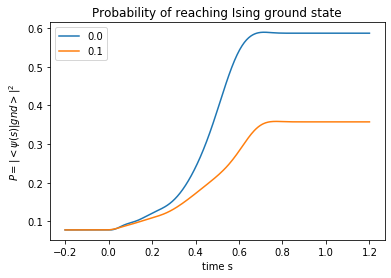

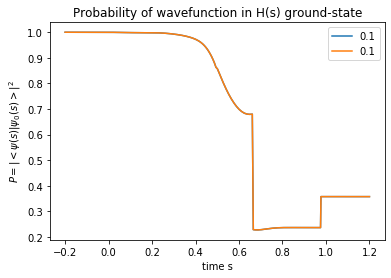

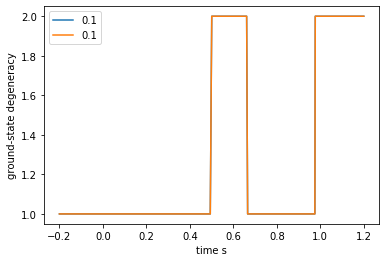

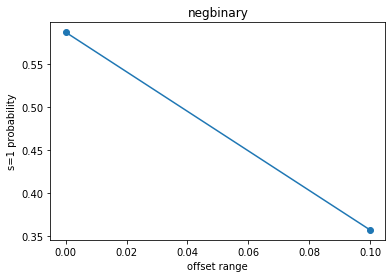

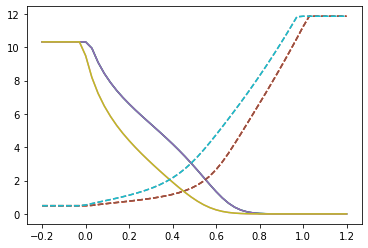

In [16]:
result = dict()
proba = dict()
proba_annealH = dict()
degen_number = dict()
plt.figure("prob(s)")
ax = plt.axes()
for offset_min in offset_min_list:
    with open(f"../qlp/mds/tdse/{embed}_{initial_wavefunction}_{offset}_{offset_min}.pickle", "rb") as file:
        rpickle = pickle.load(file)
        offset_range = -2*offset_min
        result[offset_range] = rpickle["tdse"]
        proba[offset_range] = rpickle["overlap"][-1]
        proba_annealH[offset_range] = rpickle["overlap_annealH"][-1]
        degen_number[offset_range] = rpickle["degen_number"]
    ax.errorbar(x=rpickle["sol"].t, y=rpickle["overlap"], label=offset_range)
ax.legend()
ax.set_xlabel('time s')
ax.set_ylabel(r'$P= |<\psi (s) | gnd >|^2$')
plt.title('Probability of reaching Ising ground state')
plt.savefig("./proba.pdf")
plt.show()

plt.figure("annealH prob(s)")
ax = plt.axes()
for offset_min in offset_min_list:
    ax.errorbar(x=rpickle["sol"].t, y=rpickle["overlap_annealH"], label=offset_range)
ax.legend()
ax.set_xlabel('time s')
ax.set_ylabel(r'$P= |<\psi (s) | \psi_0(s) >|^2$')
plt.title('Probability of wavefunction in H(s) ground-state')
plt.show()

plt.figure("degeneracy number")
ax = plt.axes()
for offset_min in offset_min_list:
    ax.errorbar(x=rpickle["sol"].t, y=rpickle["degen_number"], label=offset_range)
ax.legend()
ax.set_xlabel('time s')
ax.set_ylabel(r'ground-state degeneracy')
plt.show()

plt.figure("prob final")
ax=plt.axes()
ax.errorbar(x=list(proba.keys()), y=list(proba.values()), marker="o")
ax.set_xlabel('offset range')
ax.set_ylabel('s=1 probability')
plt.title(offset)
plt.show()

# plot last anneal schedule
plt.figure()
ax = plt.axes()
X = np.linspace(*normalized_time)
yA = np.array([tdse.AS.A(Xi) for Xi in X])
yB = np.array([tdse.AS.B(Xi) for Xi in X])
for qubit in range(len(yA[0])):
    ax.errorbar(x=X, y=yA[:, qubit])
    ax.errorbar(x=X, y=yB[:, qubit], ls='--')

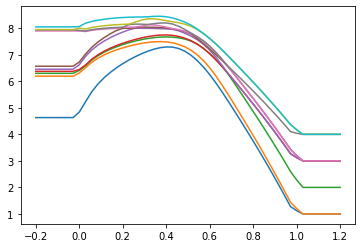

ground state energy: 0.9999999999999201
1st ex state energy: 0.9999999999999272
ground state eigvec: [ 0.  0. -1.  0.  0.  0.  0.  0.  0. -0. -0. -0.  0. -0.  0.  0.  0. -0.
  0. -0. -0.  0.  0.  0. -0. -0. -0. -0.  0. -0.  0. -0.]
1st ex state eigvec: [-0.  0. -0.  0. -0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0. -0. -0.
  0.  0.  0.  0. -0. -0.  0. -0.  1.  0.  0.  0. -0.  0.]


In [4]:
# unit conversion
# sol.y = [GHz / h]
make_dimensionless = 1/energyscale * 1/tdse.AS.B(normalized_time[1])[0]

fig = plt.figure()
ax = plt.axes()
num_es = 10
gap = dict()
for key in result.keys():
    x = []
    y = {es: [] for es in range(num_es)}
    for s in np.linspace(normalized_time[0], normalized_time[1]):
        eigval, eigvec = eigh(result[key].annealingH(s))
        seigval = np.sort(eigval)*make_dimensionless + ising_params['c'] + qubo_constant
        x.append(s)
        for es in y.keys():
            y[es].append(seigval[es])
    for es in y.keys():
        ax.errorbar(x=x, y=y[es])
    gap[key] = {es: np.array(y[es]) - np.array(y[0]) for es in y.keys()}
plt.draw()
plt.show()
print("ground state energy:", y[0][-1])
print("1st ex state energy:", y[1][-1])
eigval, eigvec = eigh(result[key].annealingH(s))
print("ground state eigvec:", np.round(eigvec[0]))
print("1st ex state eigvec:", np.round(eigvec[1]))


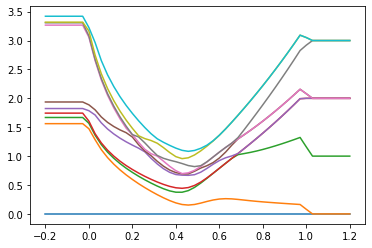

In [5]:
fig = plt.figure()
ax = plt.axes()
for key in gap.keys():
    for es in gap[key].keys():
        ax.errorbar(x=x, y=gap[key][es], label=es)
#ax.legend()
plt.draw()
plt.show()
#print(f"e1-e0 gap[offset_range={min(gap.keys())}][{sum(mask)}]:", gap[min(gap.keys())][sum(mask)][-1])
#print(f"e2-e0 gap[offset_range={min(gap.keys())}][{sum(mask)+1}]:", gap[min(gap.keys())][sum(mask)+1][-1])

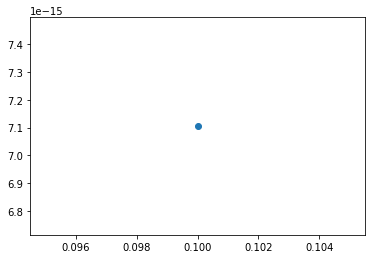

{0.1: 7.105427357601002e-15}

In [6]:
mingap = {key: min(gap[key][1]) for key in gap.keys()}
plt.figure()
ax = plt.axes()
x = list(mingap.keys())
y = list(mingap.values())
ax.errorbar(x=x, y=y, marker="o")
plt.draw()
plt.show()
mingap

In [7]:
sol.t

array([-2.00000000e-01, -1.97359457e-01, -1.94718913e-01, -1.92076538e-01,
       -1.89434164e-01, -1.86791791e-01, -1.84149417e-01, -1.81507043e-01,
       -1.78864669e-01, -1.76222295e-01, -1.73579921e-01, -1.70937548e-01,
       -1.68295174e-01, -1.65652800e-01, -1.63010426e-01, -1.60368052e-01,
       -1.57725678e-01, -1.55083304e-01, -1.52440930e-01, -1.49798556e-01,
       -1.47156182e-01, -1.44513808e-01, -1.41871434e-01, -1.39229060e-01,
       -1.36586686e-01, -1.33944312e-01, -1.31301938e-01, -1.28659564e-01,
       -1.26017189e-01, -1.23374815e-01, -1.20732441e-01, -1.18090067e-01,
       -1.15447693e-01, -1.12805319e-01, -1.10162944e-01, -1.07520570e-01,
       -1.04878196e-01, -1.02235822e-01, -9.95934475e-02, -9.69510732e-02,
       -9.43086989e-02, -9.16663246e-02, -8.90239503e-02, -8.63815760e-02,
       -8.37392016e-02, -8.10968272e-02, -7.84544529e-02, -7.58120785e-02,
       -7.31697040e-02, -7.05273296e-02, -6.78849552e-02, -6.52425807e-02,
       -6.26002063e-02, -